<a href="https://colab.research.google.com/github/keerthanab2201/Sentiment-Analysis-using-Deep-Learning/blob/main/distilBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# 1️⃣ In Colab, install dependencies
!pip install transformers datasets --quiet

# 2️⃣ Mount Drive or upload your dataset
from google.colab import drive
drive.mount('/content/drive')

# 3️⃣ Import libraries
import pandas as pd, numpy as np, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from transformers import create_optimizer

df= pd.read_csv("/content/drive/MyDrive/datasets/Amazon-Product-Reviews-Sentiment-Analysis-in-Python-Dataset.csv")
df.to_json("amazon_reviews_data.json", orient="records", lines=True)
print("✅ Conversion complete: Saved as reviews_data.json")

# 4️⃣ Load & label data
df = pd.read_json("amazon_reviews_data.json", lines=True)
df = df[['Review','Sentiment']].dropna()
df = df[df['Sentiment'] != 3]
df['label'] = (df['Sentiment'] >= 4).astype(int)

# 5️⃣ Train/Val/Test split (70/10/20)
X_train, X_temp, y_train, y_temp = train_test_split(df['Review'], df['label'], test_size=0.30, stratify=df['label'], random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, stratify=y_temp, random_state=42)

# 6️⃣ Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
def tokenize(texts):
    return tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=256, return_tensors='tf')

train_enc = tokenize(X_train)
val_enc   = tokenize(X_val)
test_enc  = tokenize(X_test)

# 7️⃣ TF Datasets with small batch size
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), y_train.values)).shuffle(1000).batch(8)
val_ds   = tf.data.Dataset.from_tensor_slices((dict(val_enc), y_val.values)).batch(8)
test_ds  = tf.data.Dataset.from_tensor_slices((dict(test_enc), y_test.values)).batch(8)

# 8️⃣ Load model & compile
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

steps_per_epoch = len(train_ds)
num_train_steps = steps_per_epoch * 3
optimizer, lr_schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=num_train_steps)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 9️⃣ Train with GPU safe settings
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)],
                    verbose=1)

# 10️⃣ Evaluate
logits = model.predict(test_ds).logits
preds = np.argmax(logits, axis=1)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds, digits=4))

# ✅ Optional: Save model to Drive
model.save_pretrained('/content/drive/MyDrive/distilbert_sentiment')
tokenizer.save_pretrained('/content/drive/MyDrive/distilbert_sentiment')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Conversion complete: Saved as reviews_data.json


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were n

Epoch 1/3
1750/1750 [==============================] - 422s 227ms/step - loss: 0.2474 - accuracy: 0.9021 - val_loss: 0.1867 - val_accuracy: 0.9250
Epoch 2/3
1750/1750 [==============================] - 392s 224ms/step - loss: 0.1182 - accuracy: 0.9597 - val_loss: 0.2044 - val_accuracy: 0.9295
Epoch 3/3
500/500 [==============================] - 40s 76ms/step
[[1808  192]
 [ 108 1892]]
              precision    recall  f1-score   support

           0     0.9436    0.9040    0.9234      2000
           1     0.9079    0.9460    0.9265      2000

    accuracy                         0.9250      4000
   macro avg     0.9258    0.9250    0.9250      4000
weighted avg     0.9258    0.9250    0.9250      4000



('/content/drive/MyDrive/distilbert_sentiment/tokenizer_config.json',
 '/content/drive/MyDrive/distilbert_sentiment/special_tokens_map.json',
 '/content/drive/MyDrive/distilbert_sentiment/vocab.txt',
 '/content/drive/MyDrive/distilbert_sentiment/added_tokens.json',
 '/content/drive/MyDrive/distilbert_sentiment/tokenizer.json')

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Get predictions
logits = model.predict(test_ds).logits
y_pred = np.argmax(logits, axis=1)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nAccuracy     : {accuracy:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")

500/500 [==============================] - 43s 86ms/step
Confusion Matrix:
[[1808  192]
 [ 108 1892]]

Accuracy     : 0.9250
Precision    : 0.9079
Recall       : 0.9460
F1 Score     : 0.9265


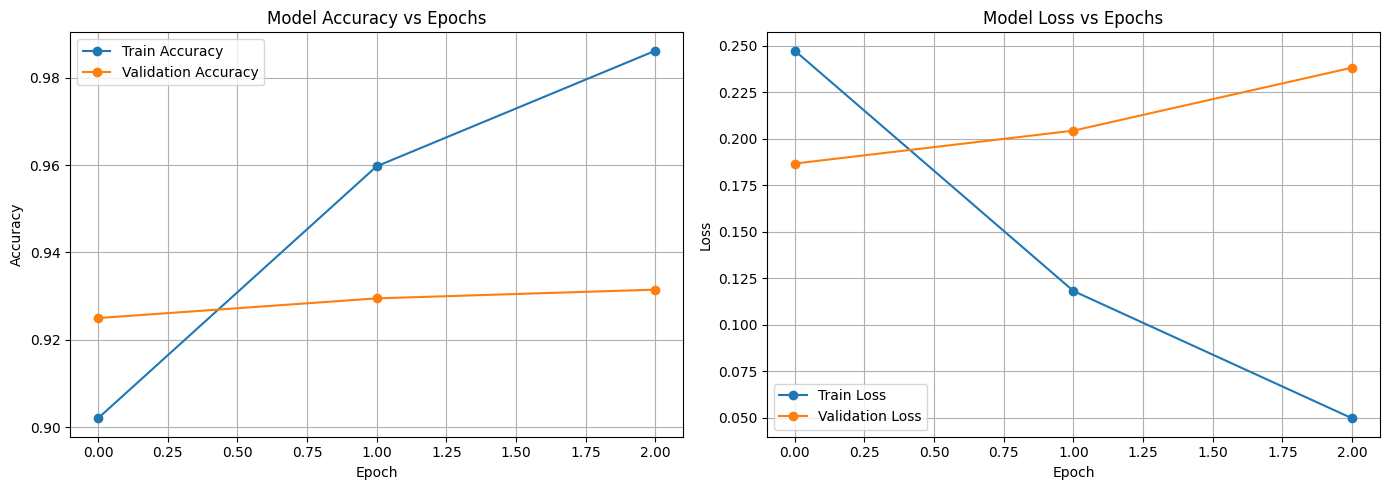

In [6]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()